In [227]:
#Basic imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import librosa
import glob
import requests
from urllib.request import urlopen
import time

In [228]:
def read_csv(path):
    df = pd.read_csv(path)
    return df

In [229]:
def plot_df(df,name):
    plt.hist(df[name]) 
    plt.show()

In [230]:
def plot_val(arr):
    plt.hist(arr)
    plt.show()

In [231]:
Notes = ['C0', 'C#0', 'D0', 'D#0', 'E0', 'F0', 'F#0', 'G0', 'G#0', 'A0', 'A#0', 'B0','C1', 'C#1', 'D1', 'D#1', 'E1', 'F1', 'F#1', 'G1', 'G#1', 'A1', 'A#1', 'B1','C2', 'C#2', 'D2', 'D#2', 'E2', 'F2', 'F#2', 'G2', 'G#2', 'A2', 'A#2', 'B2','C3', 'C#3', 'D3', 'D#3', 'E3', 'F3', 'F#3', 'G3', 'G#3', 'A3', 'A#3', 'B3','C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'A4', 'A#4', 'B4','C5', 'C#5', 'D5', 'D#5', 'E5', 'F5', 'F#5', 'G5', 'G#5', 'A5', 'A#5', 'B5','C6', 'C#6', 'D6', 'D#6', 'E6', 'F6', 'F#6', 'G6', 'G#6', 'A6', 'A#6', 'B6','C7', 'C#7', 'D7', 'D#7', 'E7', 'F7', 'F#7', 'G7', 'G#7', 'A7', 'A#7', 'B7','C8', 'C#8', 'D8', 'D#8', 'E8', 'F8', 'F#8', 'G8', 'G#8', 'A8', 'A#8', 'B8']

In [232]:
def get_notes_from_hz(Notes):
    notes_values=[]
    for i in Notes:
        notes_values.append(librosa.note_to_hz(i))
    return np.array(notes_values)

In [233]:
def find_closest(arr, val,Notes):
       idx = np.abs(arr - val).argmin()
       return abs(arr[idx]-val),Notes[idx]

In [234]:
def calculate_cents(f1,f2):
    cents=(1200*(np.log(f2/f1)))/np.log(2)
    return abs(cents)

In [235]:
def get_cents(notes_values, tonic,cent_th):
    cent_lst=[]
    for i in notes_values:
        cent_lst.append(calculate_cents(tonic,i))
    cent_lst=np.array(cent_lst)
    cent=cent_lst[cent_lst<cent_th]
    return len(cent)

In [236]:
def count_equal_temporal_values(notes_values,Notes,tonics,cent_th):
    count_eq=0
    for i in tonics:
        c=get_cents(notes_values, i,cent_th)
        count_eq+=c
    return count_eq

In [237]:
def get_diff_tonics(notes_values,Notes,tonics):
    diff=[]
    note=[]
    for i in tonics:
        d,n=find_closest(notes_values, i,Notes)
        diff.append(d)
        note.append(n)
    return diff,note

In [238]:
def get_files_in_folders(path,filetype):
    filelist = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if(file.endswith(filetype)):
                filelist.append(os.path.join(root,file))
    return filelist

In [239]:
def read_txt(path):
    with open(path) as f:
        lines = f.readline()
        tonic=lines.split("\n")
    return float(tonic[0])

In [240]:
def get_tonic_from_txt(filelist):
    tonic_lst=[]
    for i in filelist:
        tonic_lst.append(read_txt(i))
    return tonic_lst

In [241]:
def get_column_from_df(df,name):
    return list(df[name])

In [242]:
def try_url(url):
    try:
        response = urlopen(url)
        data_json = json.loads(response.read()) 
        return data_json
    except:
        return "Bad_Request"

In [243]:
def get_data_from_mbid(mbid):
    if mbid=="-1":
        return "mbid_missing"
    else:
        url = "https://musicbrainz.org/ws/2/recording/"+mbid+"/?fmt=json"
        print(url)
        result=try_url(url)
        time.sleep(0.2)
        if result=="Bad_Request":
            pass
        else:
            return result

In [244]:
def get_list_of_data_from_mbid(mbids):
    data=[]
    #c=1
    for i in mbids:
        #print(c)
        data.append(get_data_from_mbid(i))
        #c+=1
    return data

In [245]:
def try_fetch_date(d,param):
    try:
        val=d[param]
        return val
    except:
        val="DNA"
        return val

In [246]:
def load_json(path):
    f = open(path)
    data = json.load(f)
    return data

In [247]:
def get_info_from_mbid_data(mbid_api_data,param):
    info=[]
    for i in mbid_api_data:
        if type(i)==dict:
            val=try_fetch_date(i,param)
            info.append(val)
        else:
            info.append("mbid_missing")
    return info

In [248]:
def process_date(date):
    new_date=[]
    for i in date:
        if i=="DNA":
            new_date.append(i)
        elif i=="mbid_missing":
            new_date.append(i)
        else:
            new_date.append(i[:4])
    return new_date

In [249]:
def count_values(arr,th):
    c=0
    for i in arr:
        if i<th:
            c+=1
    return c

In [250]:
def split_dataframe_by_year(df):
    sorted_df = df.sort_values(by=['year'], ascending=True)
    years= sorted_df['year'].unique()
    data=[]
    for i in years:
        data.append(sorted_df[sorted_df['year']==i])
    return data,years

In [251]:
def split_dataframe_by_artist(df):
    sorted_df = df.sort_values(by=['year'], ascending=True)
    artists= sorted_df['artist'].unique()
    data=[]
    for i in artists:
        data.append(sorted_df[sorted_df['artist']==i])
    return data,artists

In [252]:
def split_dataframe_by_year_artist(df):
    arr=df['year'].unique()
    res=[]
    for i in arr:
        res.append(df[df["year"]==i])
    return res

In [253]:
def get_tonic_avg(df):
    arr= split_dataframe_by_year_artist(df)
    year=[]
    avg_tonic=[]
    for i in arr:
        avg_tonic.append(sum(i["tonic"])/len(i["tonic"]))
        year.append(i['year'].unique())
    return year,avg_tonic

In [254]:
def get_ratio(diff,th):
    ratio=[]
    count=[]
    count_d=[]
    for i in range(len(diff)):
        ratio.append(count_values(diff[i],th)/len(diff[i]))
        count.append(len(diff[i]))
        count_d.append(count_values(diff[i],th))
    return ratio,count,count_d

In [255]:
def print_data_for_comparison(ratio,count,year,count_d):
    for i in range(len(ratio)):
        print(year[i],end=" ")
        print(count[i],count_d[i],ratio[i])

In [256]:
# df=read_csv("all_data_updated.csv")
# df
# mbids=get_column_from_df(df,"mbid")
# mbid_data=get_list_of_data_from_mbid(mbids)
# mbid_api_data=load_json("mbid_data.json")
# date=get_info_from_mbid_data(mbid_api_data,"first-release-date")
# processed_date=process_date(date)
# print(processed_date.count("mbid_missing"))
# print(processed_date.count("DNA"))

In [257]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [258]:
mbid_api_data=load_json("/drive/My Drive/Tonic_Identification/mbid_data.json")

In [259]:
df=read_csv("/drive/My Drive/Tonic_Identification/all_data_with_date.csv")
df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,tonic,artist,gender,filepath,mbid,type,tradition,year
0,0,0,TonicDataset/CM/audio/402f49e2-5957-4b24-9229-...,161.748,L. Subramaniam,Male,TonicDataset/CM/audio/402f49e2-5957-4b24-9229-...,402f49e2-5957-4b24-9229-0c94b0c4c07d,instrumental,Carnatic,1988
1,1,1,TonicDataset/CM/audio/0640aaa2-45c8-48ef-b1ed-...,161.743,L. Subramaniam,Male,TonicDataset/CM/audio/0640aaa2-45c8-48ef-b1ed-...,0640aaa2-45c8-48ef-b1ed-7ed878d4f40c,instrumental,Carnatic,1988
2,2,2,TonicDataset/CM/audio/90c3b772-189c-411e-aea5-...,154.871,Baluji Shrivastav,unknown,TonicDataset/CM/audio/90c3b772-189c-411e-aea5-...,90c3b772-189c-411e-aea5-a7c6ee9748a7,instrumental,Hindustani,1997
3,3,3,TonicDataset/CM/audio/c5976719-6376-4522-b62e-...,161.845,L. Subramaniam,Male,TonicDataset/CM/audio/c5976719-6376-4522-b62e-...,c5976719-6376-4522-b62e-1cad0136aebc,instrumental,Carnatic,1988
4,4,4,TonicDataset/CM/audio/6f4cc2d5-b062-40f9-bdf1-...,156.456,Shashank,unknown,TonicDataset/CM/audio/6f4cc2d5-b062-40f9-bdf1-...,6f4cc2d5-b062-40f9-bdf1-eb961e6f8f45,instrumental,Carnatic,2008
...,...,...,...,...,...,...,...,...,...,...,...
2194,2194,2194,TonicDataset/IITM/audio/Tonic_Data2/TNSKamboji...,142.000,NaN,Male,TonicDataset/IITM/audio/Tonic_Data2/TNSKamboji...,-1,NaN,NaN,mbid_missing
2195,2195,2195,TonicDataset/IITM/audio/Tonic_Data3/557-TMKris...,146.750,NaN,Male,TonicDataset/IITM/audio/Tonic_Data3/557-TMKris...,-1,NaN,NaN,mbid_missing
2196,2196,2196,TonicDataset/IITM/audio/Tonic_Data2/TMKKamboji...,145.400,NaN,Male,TonicDataset/IITM/audio/Tonic_Data2/TMKKamboji...,-1,NaN,NaN,mbid_missing
2197,2197,2197,TonicDataset/IITM/audio/Tonic_Data3/032-Palgha...,135.500,NaN,Male,TonicDataset/IITM/audio/Tonic_Data3/032-Palgha...,-1,NaN,NaN,mbid_missing


In [260]:
notes_hz=get_notes_from_hz(Notes)

In [261]:
data_year_wise,years1=split_dataframe_by_year(df)
data_artist_wise,years2=split_dataframe_by_artist(df)
len(data_artist_wise)

116

In [168]:
diff,note=[],[]
for i in data_year_wise:
    d,n=get_diff_tonics(notes_hz,Notes,i["tonic"])
    diff.append(d)
    note.append(n)

In [169]:
ratio,count,count_d=get_ratio(diff,2)

In [170]:
print_data_for_comparison(ratio,count,years1,count_d)

1956 7 0 0.0
1987 3 0 0.0
1988 7 0 0.0
1989 8 0 0.0
1990 16 11 0.6875
1991 5 5 1.0
1992 46 22 0.4782608695652174
1993 12 0 0.0
1994 50 29 0.58
1995 25 10 0.4
1996 26 16 0.6153846153846154
1997 27 24 0.8888888888888888
1998 28 11 0.39285714285714285
1999 18 0 0.0
2000 24 15 0.625
2001 87 51 0.5862068965517241
2002 61 16 0.26229508196721313
2003 35 30 0.8571428571428571
2004 34 29 0.8529411764705882
2005 74 32 0.43243243243243246
2006 77 53 0.6883116883116883
2007 85 34 0.4
2008 142 75 0.528169014084507
2009 126 65 0.5158730158730159
2010 257 177 0.688715953307393
2011 244 123 0.5040983606557377
DNA 110 36 0.32727272727272727
mbid_missing 565 312 0.552212389380531


In [171]:
equi_temporal=[]
for i in data_year_wise:
    c=count_equal_temporal_values(notes_hz,Notes,i["tonic"],cent_th=10)
    equi_temporal.append(c)

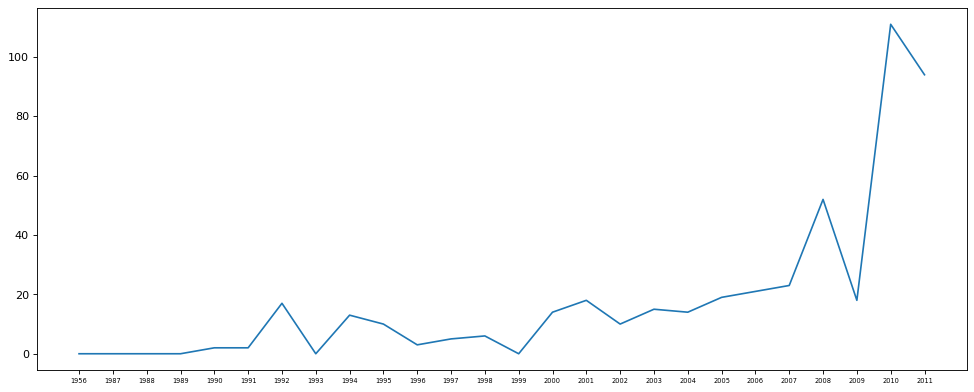

In [172]:
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(years1[:-2],equi_temporal[:-2])
plt.tick_params(axis='x', which='major', labelsize=6)
plt.show()

In [173]:
year_string = [str(i) for i in years1]

data_list = pd.DataFrame(
    {'No of Samples': count[4:-2],
     'Near to Equitempered': equi_temporal[4:-2],
     'Year': year_string[4:-2]
    })

data_list.head()

,No of Samples,Near to Equitempered,Year
0,16,2,1990
1,5,2,1991
2,46,17,1992
3,12,0,1993
4,50,13,1994


In [174]:
import plotly.express as px

fig = px.bar(data_list, x="Year", y="Near to Equitempered", color="No of Samples")
fig.update_layout(title_text='Evolution of Tonic', title_x=0.5)
fig.show()

In [175]:
increasing_tonic=[22,5,10 ,40,43 ,64 ,88 ,89 ]
octave_error=[0,2,12,24,26,28,44,60  ,61 ,69  ,72  ,84 ,99 ,110  ]
decreasing_tonic=[31,38 ,39 ,83   ,86 ]
exact_tonic=[35,103]

In [176]:
print((len(increasing_tonic)/114)*100)
print((len(decreasing_tonic)/114)*100)
print((len(octave_error)/114)*100)

7.017543859649122
4.385964912280701
12.280701754385964


In [177]:
#Analysis
#Percentage of Octave Error, artist wise and overall, Male/Female Ratio in this
#Increase tonic percentage of artists Male/Female Ratio
#Decrease tonic percentage of artists Male/Female Ratio
#Moving Towards Temporal Scale Overall 
#Moving Towards Temporal Scale Artist Wise

In [297]:
artist_analysis=[]
for i in decreasing_tonic:
    x,y=get_tonic_avg(data_artist_wise[i])
    a=data_artist_wise[i]['artist'].unique()
    artist_analysis.append([a[0],x,y])

In [298]:
def clean_data(k):
  name = k[0]
  year, tonic = [], []
  for i in range(len(k[1])):
    year.append(k[1][i][0])
  for i in range(len(k[2])):
    tonic.append(k[2][i])
  return name, year, tonic

In [299]:
name, year, tonic = [], [], []

for i in range(len(artist_analysis)):
  n, y, t = clean_data(artist_analysis[i])
  name.append(n)
  year.append(y)
  tonic.append(t)

In [300]:
import plotly.express as px

def plot_plots(name, year, tonic):
  plot_list = pd.DataFrame(
    {'Year': year,
     'Average Tonic': tonic
    })
  fig = px.line(plot_list, x='Year', y='Average Tonic')
  fig.update_layout(title_text=name, title_x=0.5)
  fig.show()

In [306]:
idx=0
plot_plots(name[idx], year[idx], tonic[idx])

In [136]:
f1=193
f2=196
cents=(1200*(np.log(f2/f1)))/np.log(2)
cents

26.703368216553447

In [286]:
increasing_tonic_gender=['Male', 'Male', 'Male', 'Male', 'Female', 'Male', 'Male', 'Male', 'Male']
itg = [8, 1]
decreasing_tonic_gender=['Male', 'Male', 'Male', 'Female', 'Male']
dtg = [4, 1]

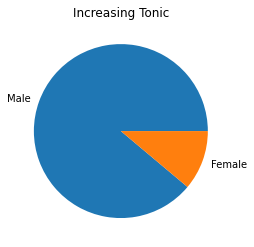

In [287]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(itg)
mylabels = ["Male", "Female"]
plt.title('Increasing Tonic')

plt.pie(y, labels=mylabels)
plt.show() 

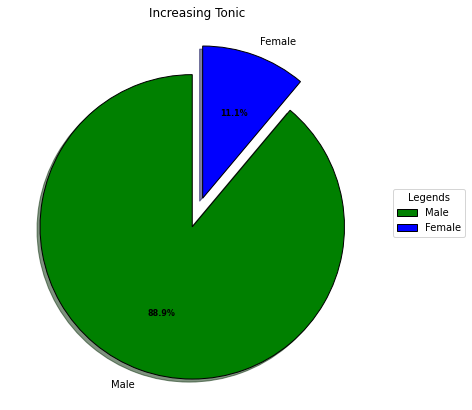

In [289]:
# Creating dataset
y = np.array(itg)
mylabels = ["Male", "Female"]
 
 
# Creating explode data
explode = (0.1, 0.1)
 
# Creating color parameters
colors = ( "green", "blue",
          "grey", "brown", "red")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(y,
                                  autopct = lambda pct: func(pct, y),
                                  explode = explode,
                                  labels = mylabels,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, mylabels,
          title ="Legends",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Increasing Tonic")
 
# show plot
plt.show()

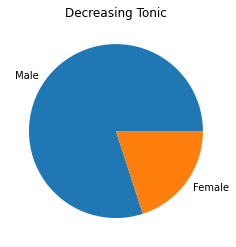

In [290]:
y = np.array(dtg)
mylabels = ["Male", "Female"]
plt.title('Decreasing Tonic')

plt.pie(y, labels=mylabels)
plt.show() 

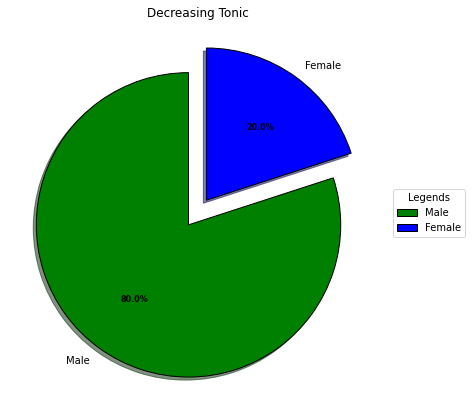

In [291]:
# Creating dataset
y = np.array(dtg)
mylabels = ["Male", "Female"]
 
 
# Creating explode data
explode = (0.1, 0.1)
 
# Creating color parameters
colors = ( "green", "blue",
          "grey", "brown", "red")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(y,
                                  autopct = lambda pct: func(pct, y),
                                  explode = explode,
                                  labels = mylabels,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, mylabels,
          title ="Legends",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Decreasing Tonic")
 
# show plot
plt.show()

In [262]:
# 116
increasing_tonic=[22,5,10 ,40,43 ,64 ,88 ,89 ]
decreasing_tonic=[31,38 ,39 ,83  ,86 ]

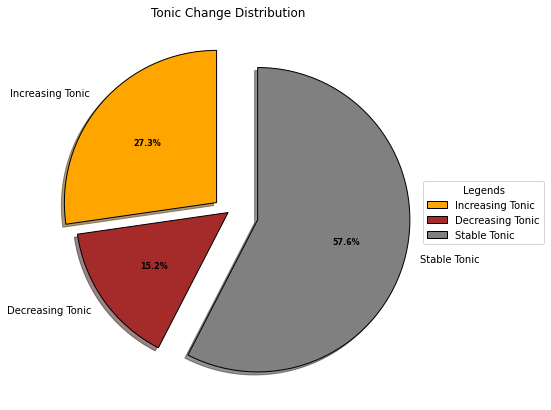

In [280]:
import numpy as np
import matplotlib.pyplot as plt
 
 
# Creating dataset
values_idt = [9, 5, 19]
label_idt = ['Increasing Tonic', 'Decreasing Tonic', 'Stable Tonic']
 
 
# Creating explode data
explode = (0.1, 0.0, 0.2)
 
# Creating color parameters
colors = ( "orange", "brown",
          "grey", "blue", "red")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(values_idt,
                                  autopct = lambda pct: func(pct, values_idt),
                                  explode = explode,
                                  labels = label_idt,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, label_idt,
          title ="Legends",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Tonic Change Distribution")
 
# show plot
plt.show()

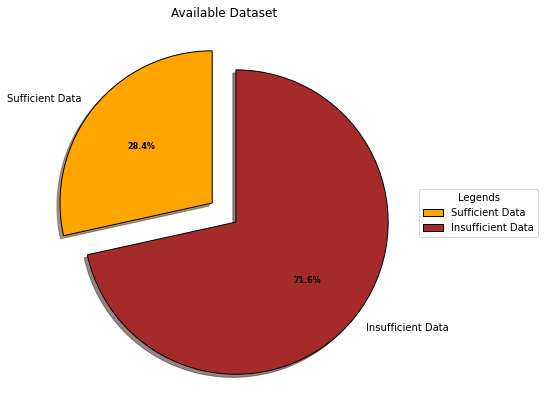

In [282]:
# Creating dataset
values_idt = [33, 83]
label_idt = ['Sufficient Data', 'Insufficient Data']
 
 
# Creating explode data
explode = (0.1, 0.1)
 
# Creating color parameters
colors = ( "orange", "brown",
          "grey", "blue", "red")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(values_idt,
                                  autopct = lambda pct: func(pct, values_idt),
                                  explode = explode,
                                  labels = label_idt,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, label_idt,
          title ="Legends",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Available Dataset")
 
# show plot
plt.show()

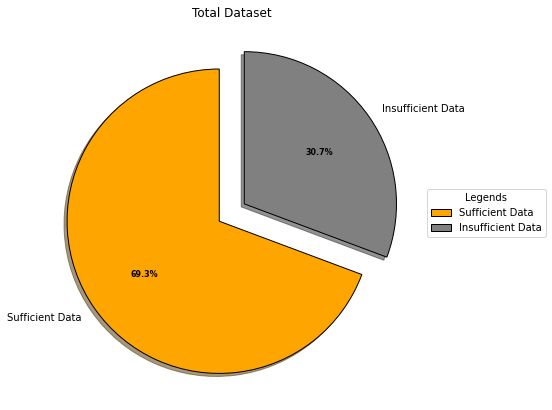

In [307]:
# Creating dataset
values_idt = [1524, 675]
label_idt = ['Sufficient Data', 'Insufficient Data']
 
 
# Creating explode data
explode = (0.1, 0.1)
 
# Creating color parameters
colors = ( "orange", "grey",
          "brown", "blue", "red")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(values_idt,
                                  autopct = lambda pct: func(pct, values_idt),
                                  explode = explode,
                                  labels = label_idt,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, label_idt,
          title ="Legends",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Total Dataset")
 
# show plot
plt.show()

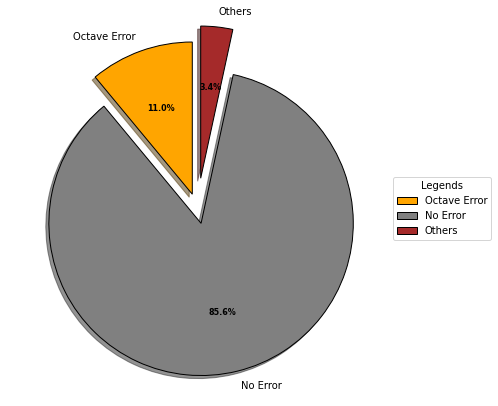

In [309]:
# Creating dataset
values_idt = [13, 101, 4]
label_idt = ['Octave Error', 'No Error', 'Others']
 
 
# Creating explode data
explode = (0.1, 0.1, 0.2)
 
# Creating color parameters
colors = ( "orange", "grey",
          "brown", "blue", "red")
 
# Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "black" }
 
# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%".format(pct, absolute)
 
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(values_idt,
                                  autopct = lambda pct: func(pct, values_idt),
                                  explode = explode,
                                  labels = label_idt,
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="black"))
 
# Adding legend
ax.legend(wedges, label_idt,
          title ="Legends",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
 
plt.setp(autotexts, size = 8, weight ="bold")
#ax.set_title("Data Observation")
 
# show plot
plt.show()